In [1]:
import os
import tempfile
import multiprocessing
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
from scvi.external import MRVI

scvi.settings.seed = 0  # optional: ensures reproducibility
print("Last run with scvi-tools version:", scvi.__version__)
save_dir = tempfile.TemporaryDirectory()

# 1) Restart the Python kernel before running this cell.
# 2) Set spawn start method BEFORE any CUDA interaction.
multiprocessing.set_start_method("spawn", force=True)

/home/mgiammar/miniconda3/envs/scvi-tools/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 0


Last run with scvi-tools version: 1.4.0.post1


In [2]:
adata_path = "sound_life_t_cd4_memory.h5ad"
adata = sc.read(adata_path)

# Filter based on highly variable genes
sc.pp.highly_variable_genes(
    adata, n_top_genes=10000, inplace=True, subset=True, flavor="seurat_v3"
)

adata

AnnData object with n_obs × n_vars = 2640499 × 10000
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawYear', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'subject.ageGroup'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [3]:
sample_key = "subject.subjectGuid"  # target covariate for MrVI
batch_key = "batch_id"  # batch covariate for MrVI

MRVI.setup_anndata(adata, sample_key=sample_key, batch_key=batch_key, backend="torch")

/tmp/ipykernel_68393/63807850.py:4: UserWarning: MRVI model is being setup with PyTorch backend
  MRVI.setup_anndata(adata, sample_key=sample_key, batch_key=batch_key, backend="torch")


In [4]:
model = MRVI(adata, backend="torch")

# batch_size passed to model.train (adjust to GPU memory)
batch_size = 512 * 16

# start training
model.train(
    max_epochs=100,
    batch_size=batch_size,
    accelerator="gpu",
    devices=1,
    # datasplitter_kwargs={"num_workers": 24}
)

/home/mgiammar/miniconda3/envs/scvi-tools/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mgiammar/miniconda3/envs/scvi-tools/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


/home/mgiammar/miniconda3/envs/scvi-tools/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mgiammar/miniconda3/envs/scvi-tools/lib/python ...
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Training for 100 epochs.
Using default DataSplitter for training.
Using provided datamodule for training.
Before trainer setup.
After trainer setup.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/mgiammar/miniconda3/envs/scvi-tools/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/mgiammar/miniconda3/envs/scvi-tools/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/mgiammar/miniconda3/envs/scvi-tools/lib/python3.13/site-packages/lightning/pytorch/loops/fit_loop.py:534: Found 1 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 100/100: 100%|██████████| 100/100 [2:00:17<00:00, 72.05s/it, v_num=1, train_loss=1.78e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [2:00:17<00:00, 72.18s/it, v_num=1, train_loss=1.78e+3]


In [5]:
# Save the model
model.save("mrvi_model_cd4_memory_plus_hvg", save_anndata=True, overwrite=True)

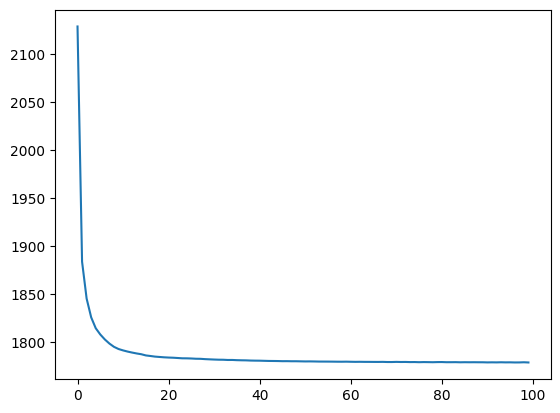

In [6]:
plt.plot(model.history["elbo_train"])

In [7]:
u = model.get_latent_representation(batch_size=batch_size)

In [8]:
z = model.get_latent_representation(batch_size=batch_size, give_z=True)

In [9]:
adata.obsm["u"] = u
adata.obsm["z"] = z